<a href="https://colab.research.google.com/github/claudio1975/PyDataVenice/blob/main/GPTForecast_CP_NVIDIA_eow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [1]:
!pip install nixtla==0.7.0 &>/dev/null

In [2]:
!pip install yfinance==0.2.65 &>/dev/null

In [3]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [4]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta
#
# Statistics and Plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
# TimeGPT
# ==============================================================================
from nixtla import NixtlaClient
from utilsforecast.preprocessing import fill_gaps
from sklearn.metrics import mean_squared_error


In [6]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

In [7]:
# Utils
# ==============================================================================
import re
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")


### TimeGPT setup

In [8]:
# Set your OpenAI API key for RAGAS evaluation (using GPT-4o)
root_folder="/content/"
_ = load_dotenv(root_folder + "nixtla.env") # read local .env file

nixtla_api_key = os.getenv("NIXTLA_API_KEY")

nixtla_client = NixtlaClient(
    api_key = nixtla_api_key
)


### Data

In [9]:
stock_ticker = yf.Ticker("NVDA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-26 00:00:00-04:00,13.386138,13.651079,12.998820,13.101257,336896000,0.0,0.0
2020-10-27 00:00:00-04:00,13.265505,13.401092,13.151354,13.355980,250520000,0.0,0.0
2020-10-28 00:00:00-04:00,13.157835,13.219646,12.570628,12.588573,376520000,0.0,0.0
2020-10-29 00:00:00-04:00,12.799427,13.152599,12.711196,12.984363,320080000,0.0,0.0
2020-10-30 00:00:00-04:00,12.810892,12.897128,12.262565,12.495853,416820000,0.0,0.0
2020-11-02 00:00:00-05:00,12.619230,12.797685,12.357280,12.542464,299652000,0.0,0.0
2020-11-03 00:00:00-05:00,12.669824,13.065117,12.564396,12.979877,272900000,0.0,0.0
2020-11-04 00:00:00-05:00,13.348503,13.785420,13.296413,13.752271,410228000,0.0,0.0
2020-11-05 00:00:00-05:00,14.119400,14.295362,13.948422,14.116907,319028000,0.0,0.0


In [10]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

# Convert 'ds' to datetime, handling timezone if necessary
df['ds'] = pd.to_datetime(df['ds'])

# Extract the date part in 'YYYY-MM-DD' format
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y
0,2020-10-26,13.101257
1,2020-10-27,13.355980
2,2020-10-28,12.588573
3,2020-10-29,12.984363
4,2020-10-30,12.495853


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1256 non-null   object 
 1   y       1256 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [12]:
# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Set 'ds' as index
df.set_index('ds', inplace=True)

# Create a daily date range
start_date = df.index.min()
end_date = df.index.max()
daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame
df_daily = df.reindex(daily_dates)
df_daily.index.name = 'ds'

# Forward fill missing 'y' values
df_daily_filled = df_daily.ffill()

# Reset index to have 'ds' as a column
df_end = df_daily_filled.reset_index()
df_end.head()


,ds,y
0,2020-10-26,13.101257
1,2020-10-27,13.355980
2,2020-10-28,12.588573
3,2020-10-29,12.984363
4,2020-10-30,12.495853


In [13]:
test_size=90

In [14]:
train=df_end.iloc[:-test_size]
test=df_end.iloc[-test_size:]


In [15]:
train.shape, test.shape

((1735, 2), (90, 2))

In [16]:
print(train.min())
print(train.max())

ds    2020-10-26 00:00:00
y               11.213529
dtype: object
ds    2025-07-26 00:00:00
y              173.730209
dtype: object


In [17]:
print(test.min())
print(test.max())

ds    2025-07-27 00:00:00
y               167.01059
dtype: object
ds    2025-10-24 00:00:00
y              192.570007
dtype: object


### Functions

In [18]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [19]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [20]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [21]:
def forecast_vis(train, test, prediction, ticker):
  # Reset index to ensure 'ds' is a column
  train_df = train_result.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Forecasting Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [22]:
def forecast_vis2(test, prediction, ticker):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Test and Future Conformal Prediction Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [23]:
horizon=120
timegpt_df = nixtla_client.forecast(
    df=train, h=horizon, level=[95],
    time_col='ds', target_col='y',
    add_history=True,
)
timegpt_df.head()

,ds,TimeGPT,TimeGPT-hi-95,TimeGPT-lo-95
0,2020-11-29,13.170854,20.648258,5.693449
1,2020-11-30,13.116373,20.593777,5.638969
2,2020-12-01,13.097317,20.574720,5.619913
3,2020-12-02,13.198999,20.676403,5.721595
4,2020-12-03,13.253465,20.730870,5.776061


In [24]:
# prediction of test set and the next business period
forecast_df=rename_forecast_columns(timegpt_df)
test_max_date = test['ds'].max()
forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'ds'
train_result = pd.merge(
    forecast,
    train,
    on=['ds'],
    how='left'
)

# Merge the DataFrames on 'ds'
test_result = pd.merge(
    forecast,
    test,
    on=['ds'],
    how='left'
)

# handle missing values
train_result= train_result.dropna()


# handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

### Results

In [25]:
# Calculate Metrics
train_metrics = evaluate_metrics_with_boundaries(train_result)

# Display Metrics
print(f"Train metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

Train metrics:
RMSE_Point: 3.8201
RMSE_Lower_Bound: 8.5870
RMSE_Upper_Bound: 8.2020
Coverage (%): 92.7690
Average Width: 14.9548


In [26]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 8.3531
RMSE_Lower_Bound: 25.5723
RMSE_Upper_Bound: 12.1263
Coverage (%): 82.2222
Average Width: 31.0899


In [27]:
train_result.head()

,ds,y_hat,y_hat_upper,y_hat_lower,y
0,2020-11-29,13.170854,20.648258,5.693449,13.220891
1,2020-11-30,13.116373,20.593777,5.638969,13.360714
2,2020-12-01,13.097317,20.574720,5.619913,13.349249
3,2020-12-02,13.198999,20.676403,5.721595,13.503283
4,2020-12-03,13.253465,20.730870,5.776061,13.359175


In [28]:
prediction_result.head()

,ds,y_hat,y_hat_upper,y_hat_lower
1791,2025-10-25,171.97931,213.61389,130.34473
1792,2025-10-26,171.53600,211.66956,131.40244
1793,2025-10-27,170.73514,210.78932,130.68095
1794,2025-10-28,170.28882,210.61490,129.96274
1795,2025-10-29,171.12599,207.99263,134.25935


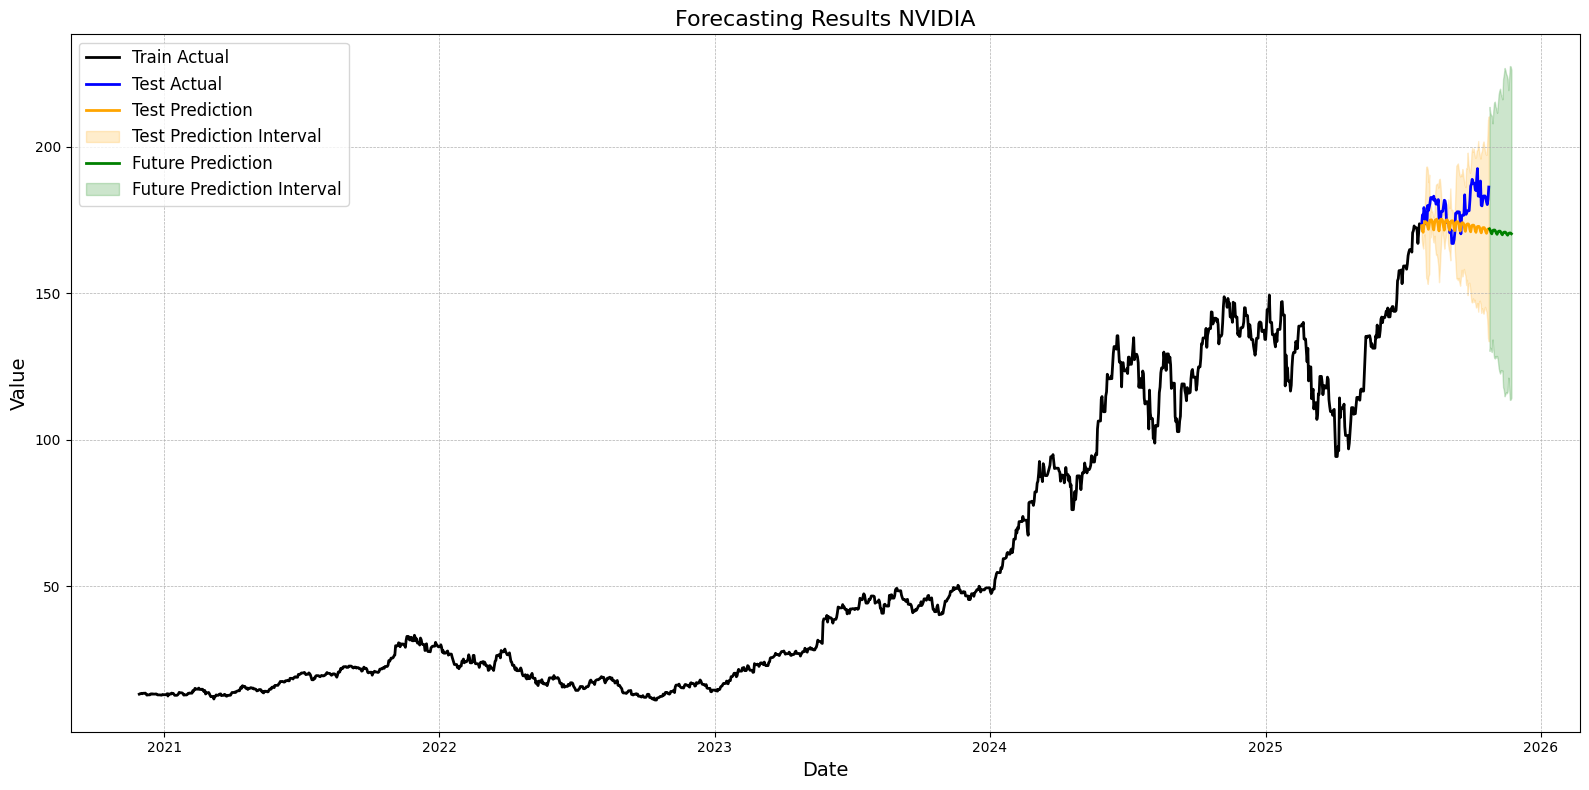

In [29]:
forecast_vis(train_result,test_result,prediction_result,"NVIDIA")

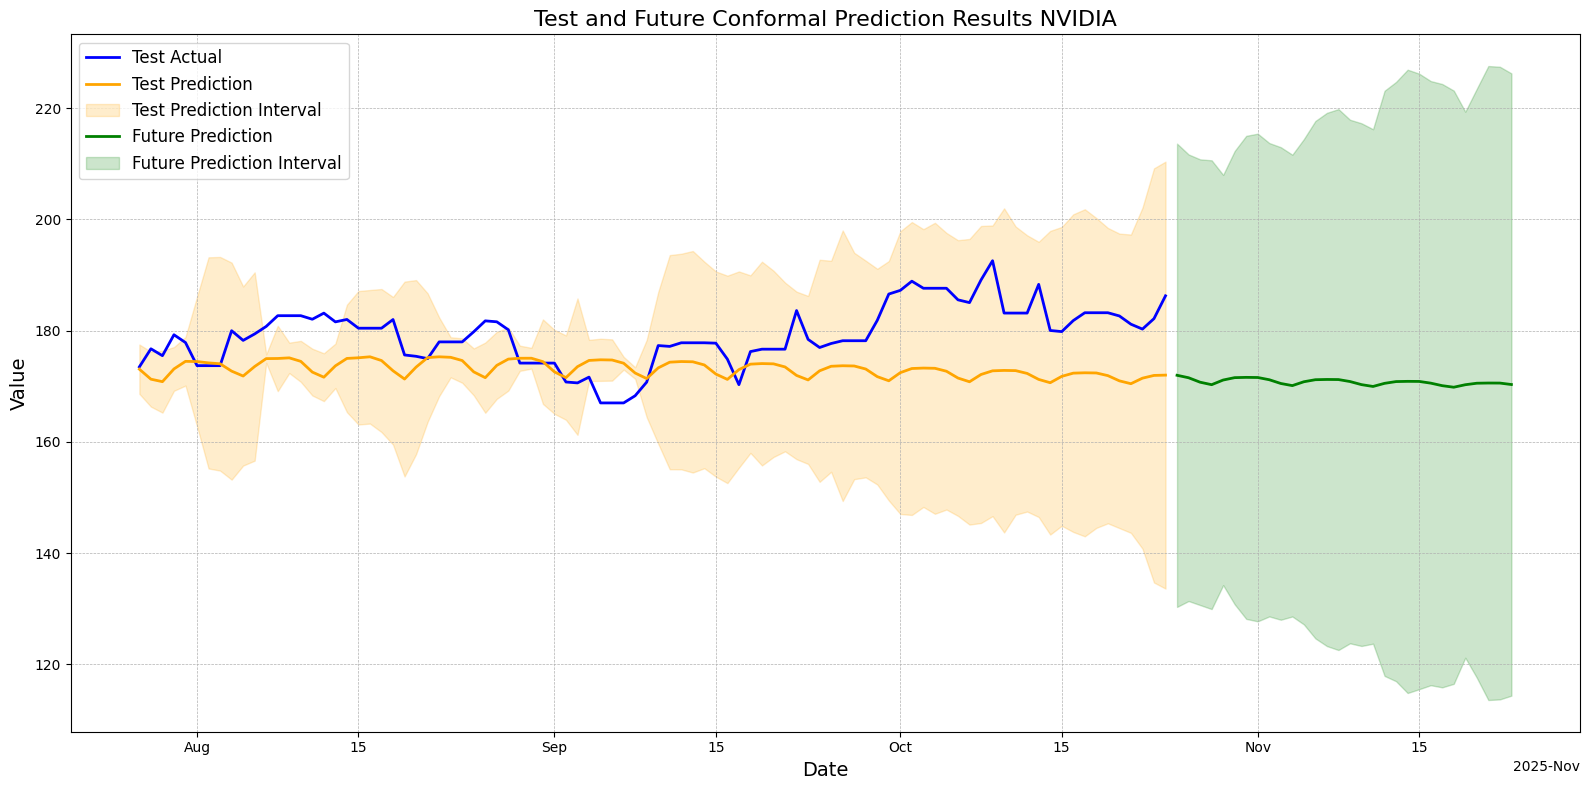

In [30]:
forecast_vis2(test_result, prediction_result,"NVIDIA")

### Prediction price

In [31]:
actual_price=df.iloc[-1]
forecast_price=prediction_result.iloc[-1]

actual_date = df.index[-1].strftime('%d-%m-%Y')
forecast_date = pd.to_datetime(forecast_price['ds']).strftime('%d-%m-%Y')

print(f"At the evaluation date of {actual_date} the stock price is {actual_price['y']}")
print(f"At the forecasting date of {forecast_date} the stock price is {forecast_price['y_hat']}")


At the evaluation date of 24-10-2025 the stock price is 186.25999450683594
At the forecasting date of 23-11-2025 the stock price is 170.31801


### References

In [32]:
# https://docs.nixtla.io/docs/getting-started-timegpt_quickstart
# https://docs.nixtla.io/docs/tutorials-prediction_intervals
# https://docs.nixtla.io/docs/tutorials-fine_tuning